Silhouette scores: [(2, 0.30381323924022696), (3, 0.2556230307526371), (4, 0.25257089117545717), (5, 0.20474808034238626), (6, 0.1683775545943057)]
Chosen K: 2
Saved clustered_meta.csv

Cluster counts:
 cluster
0    20
1    32
Name: count, dtype: int64


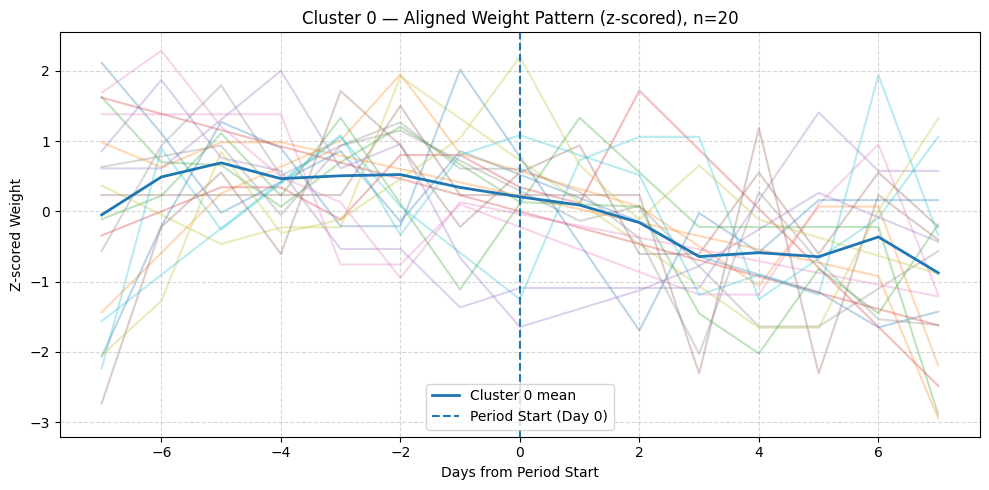

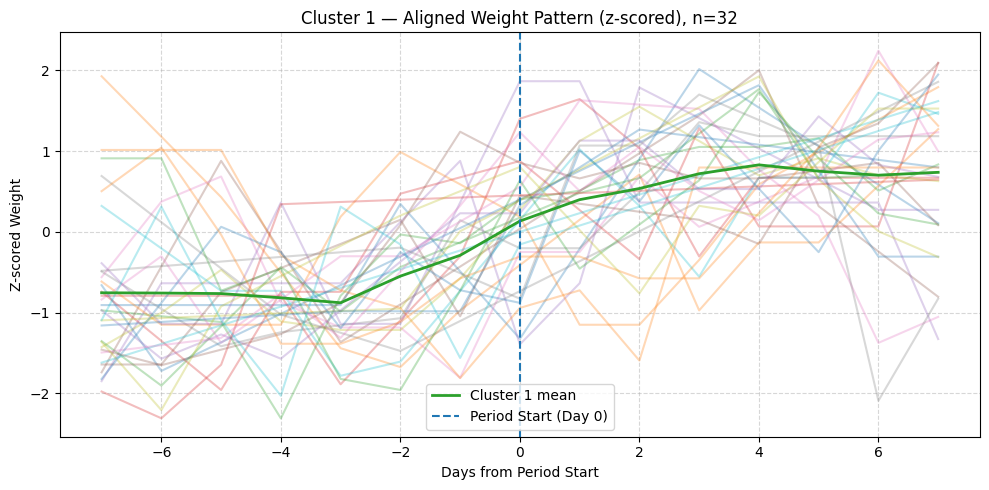


Cluster summary:
          n_cycles  mean_cycle_length  sd_cycle_length  mean_duration  \
cluster                                                                
0              20              26.95             5.11           6.10   
1              32              30.03             6.13           5.88   

         sd_duration  
cluster               
0               0.45  
1               0.42  

Season counts by cluster:
 season   Fall  Spring  Summer  Winter
cluster                              
0           6       3       7       4
1           8       8       7       9

Season % by cluster:
 season   Fall  Spring  Summer  Winter
cluster                              
0        30.0    15.0    35.0    20.0
1        25.0    25.0    21.9    28.1

Year counts by cluster:
 year     2021  2022  2023  2024  2025
cluster                              
0           1     6     7     3     3
1           6     6     6    10     4

Year % by cluster:
 year     2021  2022  2023  2024  2025
cluster 

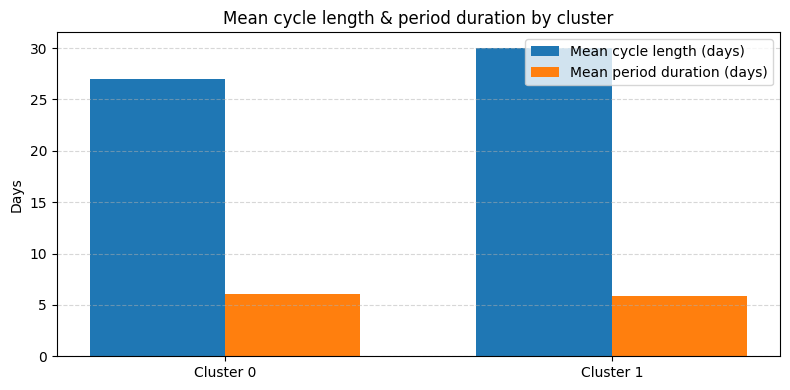

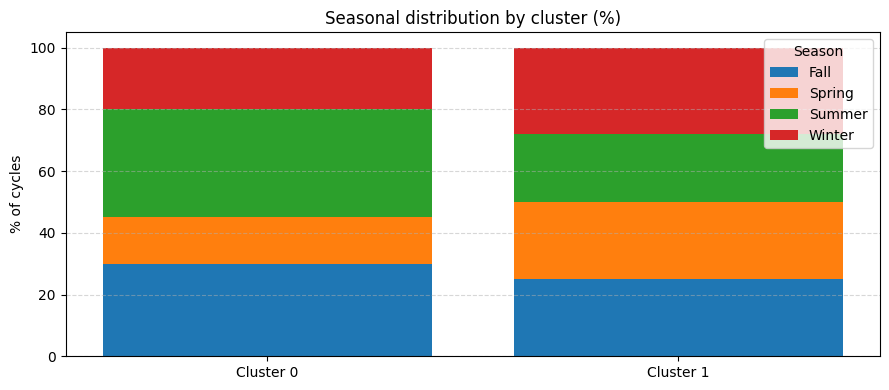

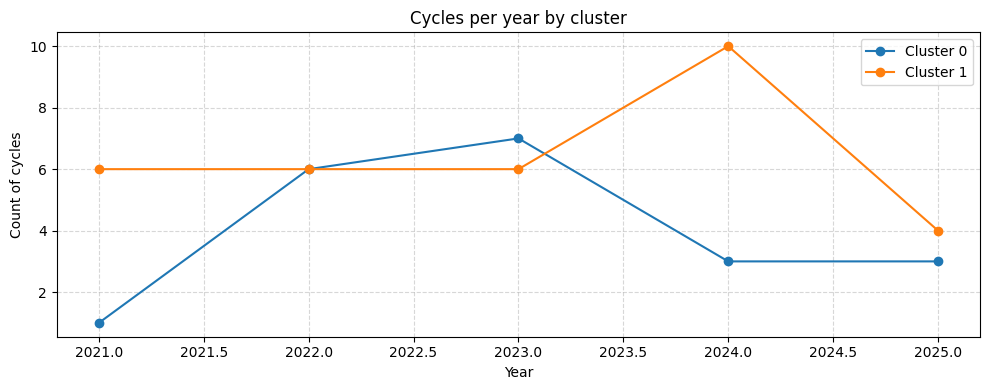

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# =========================
# Config
# =========================
WINDOW = 7                 # ± days around Period Start
MIN_VALID_POINTS = 5       # minimum non-NaN points required per cycle
K_RANGE = range(2, 7)      # candidate cluster counts
RANDOM_STATE = 42
N_INIT = 10

# =========================
# Step 0: Load Data
# =========================
def load_periods():
    if os.path.exists("period_clean.pkl"):
        return pd.read_pickle("period_clean.pkl")
    elif os.path.exists("period_clean.csv"):
        return pd.read_csv("period_clean.csv", parse_dates=["begin", "end"])
    else:
        raise FileNotFoundError("period_clean.pkl or .csv not found")

def load_weights():
    if os.path.exists("weight_clean.pkl"):
        return pd.read_pickle("weight_clean.pkl")
    elif os.path.exists("weight_clean.csv"):
        return pd.read_csv("weight_clean.csv", parse_dates=["Date"])
    else:
        raise FileNotFoundError("weight_clean.pkl or .csv not found")

# =========================
# Step 1: Align weight to Period Start
# =========================
def align_weight(df_weight, event_dates, window):
    day_range = np.arange(-window, window + 1)
    aligned = []
    for start_date in event_dates:
        if pd.isna(start_date):
            continue
        start_win = start_date - pd.Timedelta(days=window)
        end_win = start_date + pd.Timedelta(days=window)
        w = df_weight[(df_weight['Date'] >= start_win) & (df_weight['Date'] <= end_win)].copy()
        w['cycle_day'] = (w['Date'] - start_date).dt.days
        w = w.set_index('cycle_day').reindex(day_range)
        aligned.append(w['Weight'].values)
    return np.array(aligned, dtype=float), day_range

# =========================
# Step 2: Interpolate cycles
# =========================
def interpolate_cycles(arr, day_range, min_valid=5):
    kept_rows, interp_rows = [], []
    for i, row in enumerate(arr):
        if np.sum(~np.isnan(row)) < min_valid:
            continue
        s = pd.Series(row, index=day_range, dtype=float)
        s = s.interpolate(method='linear', limit_direction='both')
        interp_rows.append(s.values)
        kept_rows.append(i)
    return np.array(interp_rows, dtype=float), np.array(kept_rows, dtype=int)

# =========================
# Step 3: Z-score per cycle
# =========================
def zscore_rows(arr):
    arr_mean = np.mean(arr, axis=1, keepdims=True)
    arr_std = np.std(arr, axis=1, keepdims=True)
    arr_std[arr_std == 0] = 1.0
    return (arr - arr_mean) / arr_std

# =========================
# Step 4: Choose K
# =========================
def choose_best_k(X, k_range):
    sil_scores, best_k, best_score = [], None, -np.inf
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT)
        labels = km.fit_predict(X)
        if 1 < len(np.unique(labels)) < len(labels):
            score = silhouette_score(X, labels)
        else:
            score = -np.inf
        sil_scores.append((k, score))
        if score > best_score:
            best_score, best_k = score, k
    return best_k, sil_scores

# =========================
# Step 5: Plot cluster patterns
# =========================
def plot_cluster_patterns(X, labels, day_range):
    for c in sorted(np.unique(labels)):
        idx = np.where(labels == c)[0]
        members = X[idx]
        mean_curve = np.mean(members, axis=0)
        plt.figure(figsize=(10, 5))
        for row in members:
            plt.plot(day_range, row, alpha=0.3)
        plt.plot(day_range, mean_curve, linewidth=2, label=f'Cluster {c} mean')
        plt.axvline(0, linestyle='--', label='Period Start (Day 0)')
        plt.title(f'Cluster {c} — Aligned Weight Pattern (z-scored), n={len(idx)}')
        plt.xlabel('Days from Period Start')
        plt.ylabel('Z-scored Weight')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# =========================
# Step 6: Summary & plots
# =========================
def get_season(dt):
    m = dt.month
    if m in [12, 1, 2]: return 'Winter'
    elif m in [3, 4, 5]: return 'Spring'
    elif m in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

def summarize_clusters(df_periods, clustered_meta):
    df_joined = df_periods.merge(clustered_meta, left_on='begin', right_on='cycle_start', how='inner')
    df_joined['year'] = df_joined['begin'].dt.year
    df_joined['season'] = df_joined['begin'].apply(get_season)

    summary = df_joined.groupby('cluster').agg(
        n_cycles=('begin', 'count'),
        mean_cycle_length=('cycle_length', 'mean'),
        sd_cycle_length=('cycle_length', 'std'),
        mean_duration=('duration_days', 'mean'),
        sd_duration=('duration_days', 'std')
    ).round(2)

    season_dist = pd.crosstab(df_joined['cluster'], df_joined['season']).sort_index(axis=1)
    year_dist   = pd.crosstab(df_joined['cluster'], df_joined['year']).sort_index(axis=1)
    season_pct  = (season_dist.div(season_dist.sum(axis=1), axis=0) * 100).round(1)
    year_pct    = (year_dist.div(year_dist.sum(axis=1), axis=0) * 100).round(1)

    return summary, season_dist, season_pct, year_dist, year_pct

def plot_summary(summary, season_pct, year_dist):
    # Mean cycle length & duration
    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(summary.shape[0])
    width = 0.35
    ax.bar(x - width/2, summary['mean_cycle_length'], width, label='Mean cycle length (days)')
    ax.bar(x + width/2, summary['mean_duration'],     width, label='Mean period duration (days)')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Cluster {c}' for c in summary.index])
    ax.set_ylabel('Days')
    ax.set_title('Mean cycle length & period duration by cluster')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Season distribution (%)
    fig, ax = plt.subplots(figsize=(9, 4))
    bottom = np.zeros(len(season_pct))
    for col in season_pct.columns:
        ax.bar(season_pct.index, season_pct[col], bottom=bottom, label=col)
        bottom += season_pct[col].values
    ax.set_xticks(season_pct.index)
    ax.set_xticklabels([f'Cluster {c}' for c in season_pct.index])
    ax.set_ylabel('% of cycles')
    ax.set_title('Seasonal distribution by cluster (%)')
    ax.legend(title='Season')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Year distribution (counts)
    fig, ax = plt.subplots(figsize=(10, 4))
    for cluster, row in year_dist.iterrows():
        ax.plot(row.index, row.values, marker='o', label=f'Cluster {cluster}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count of cycles')
    ax.set_title('Cycles per year by cluster')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# =========================
# Main flow
# =========================
df_periods = load_periods()
df_weight = load_weights()

aligned_raw, day_range = align_weight(df_weight, df_periods['begin'], WINDOW)
cycle_starts = df_periods['begin'].dropna().reset_index(drop=True)

aligned_interp, kept_idx = interpolate_cycles(aligned_raw, day_range, min_valid=MIN_VALID_POINTS)
cycle_starts_kept = cycle_starts.iloc[kept_idx].reset_index(drop=True)

X = zscore_rows(aligned_interp)
best_k, sil_scores = choose_best_k(X, K_RANGE)
print("Silhouette scores:", sil_scores)
print("Chosen K:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=N_INIT)
labels = kmeans.fit_predict(X)

clustered_meta = pd.DataFrame({
    'cycle_start': cycle_starts_kept,
    'cluster': labels
}).sort_values('cycle_start').reset_index(drop=True)
clustered_meta.to_csv("clustered_meta.csv", index=False)
print("Saved clustered_meta.csv")
print("\nCluster counts:\n", clustered_meta['cluster'].value_counts().sort_index())

plot_cluster_patterns(X, labels, day_range)

summary, season_dist, season_pct, year_dist, year_pct = summarize_clusters(df_periods, clustered_meta)
print("\nCluster summary:\n", summary)
print("\nSeason counts by cluster:\n", season_dist)
print("\nSeason % by cluster:\n", season_pct)
print("\nYear counts by cluster:\n", year_dist)
print("\nYear % by cluster:\n", year_pct)

plot_summary(summary, season_pct, year_dist)

